In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math
import torch.nn as nn
import torch.nn.functional as F
import os

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    print("Using GPU", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

Using CPU


In [23]:
SEED = 42

def set_seed(seed_value=0):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [24]:
# Prime number for modular addition
P = 53

# Create the dataset
set_seed(SEED)
data = []
for i in range(P):
    for j in range(P):
        data.append([i,j,(i+j)%P])
data = np.array(data)

# Split into train and test
TRAIN_FRACTION = 0.5
np.random.shuffle(data)
train_data = data[:int(len(data) * TRAIN_FRACTION)]
test_data = data[int(len(data) * TRAIN_FRACTION):]

# Convert to tensors and create dataloaders with batch size
BATCH_SIZE = len(train_data)
BATCH_NUM = math.ceil(len(train_data)/BATCH_SIZE)

train_data = torch.tensor(train_data, dtype=torch.long, device=device)
test_data = torch.tensor(test_data, dtype=torch.long, device=device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
D_EMBED = 128
HIDDEN = 256

class EmbeddingConcatFFModel(nn.Module):
    def __init__(self):
        super(EmbeddingConcatFFModel, self).__init__()
        self.embed = nn.Embedding(P, D_EMBED)
        self.linear1 = nn.Linear(2 * D_EMBED, HIDDEN)   # 2 * D_EMBED because we concatenate the two embedded tokens
        self.linear2 = nn.Linear(HIDDEN, P)
        # self.init_weights()
        
    def forward(self, x1, x2):
        print(x1)
        x1 = self.embed(x1)
        x2 = self.embed(x2)
        x = torch.cat((x1, x2), dim=1)  # Concatenate the embedding of the two tokens
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
    '''
    # Weight initialization
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.xavier_normal_(m.weight)               
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    '''

In [34]:
TOTAL_STEPS = 10000
NB_EPOCHS = math.ceil(TOTAL_STEPS/BATCH_NUM)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1

set_seed(SEED)
model = EmbeddingConcatFFModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Recording
REPORT_INTERVAL = 200    # How often we print

step = []
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

In [35]:
for epoch in range(NB_EPOCHS):
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch in train_loader:
        x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
        optimizer.zero_grad()
        output = model(x1,x2)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == y).sum().item()
        
    step.append(epoch*(BATCH_NUM))
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc /= len(train_data)
    train_acc_history.append(train_acc)
    
    # Testing phase
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for batch in test_loader:
            x1, x2, y = batch[:,0], batch[:,1], batch[:,2]
            output = model(x1,x2)
            loss = criterion(output, y)
            test_loss += loss.item()
            test_acc += (output.argmax(dim=1) == y).sum().item()
        
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
        test_acc /= len(test_data)
        test_acc_history.append(test_acc)
        
    if epoch % REPORT_INTERVAL == 0:
        print(f"{epoch}/{NB_EPOCHS}: Train loss={train_loss:.4f}, acc={100*train_acc:.1f}%  /  Test loss={test_loss:.4f}, acc={100*test_acc:.1f}%")

tensor([[ 0.6289, -0.0685, -1.2115,  ...,  0.1415,  1.8377, -0.2277],
        [ 1.2518, -0.3599, -0.4399,  ...,  1.2511, -1.9372, -1.2051],
        [ 0.2813,  0.0870, -0.2571,  ..., -0.0899,  1.2097,  0.8767],
        ...,
        [-0.2949, -0.2799,  1.0837,  ...,  1.2978,  0.3286,  0.1487],
        [-0.9635, -1.0543, -0.6110,  ...,  0.8407, -0.1939, -0.1404],
        [-1.2321,  1.5100, -0.4955,  ...,  0.1757,  0.2550,  0.8070]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 1.9260,  1.4848,  0.8988,  ...,  0.3405,  0.7182,  0.4100],
        [-0.5182,  1.8516,  1.8337,  ...,  1.6585, -2.6206, -0.4305],
        [ 0.1059, -0.1024,  0.0839,  ...,  0.6965,  0.0531,  0.2869],
        ...,
        [-0.6728, -1.8884, -1.8396,  ..., -0.1197,  1.6041,  0.0870],
        [ 0.2820,  0.0859, -0.2578,  ..., -0.0888,  1.2095,  0.8748],
        [-0.9635, -1.0523, -0.6094,  ...,  0.8409, -0.1927, -0.1392]])
tensor([[-0.6006, -0.0589,  0.2982,  1.6301, -1.4949, -0.2984, -0.4150, -0.7815,
         -1.50

KeyboardInterrupt: 

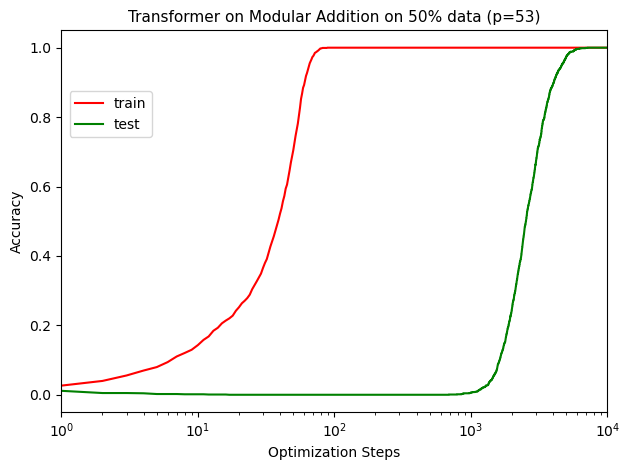

In [31]:
figure_acc = plt.subplot(1, 1, 1)
plt.plot(step, train_acc_history, color='red', label='train')
plt.plot(step, test_acc_history, color='green', label='test')
plt.legend()
plt.xlabel("Optimization Steps")
plt.xlim(1, TOTAL_STEPS)
figure_acc.set_ylabel("Accuracy")

plt.xscale('log')
plt.legend(loc=(0.015, 0.72))
plt.title(f"Transformer on Modular Addition on {int(100*TRAIN_FRACTION)}% data (p={P})", fontsize=11)
plt.tight_layout()

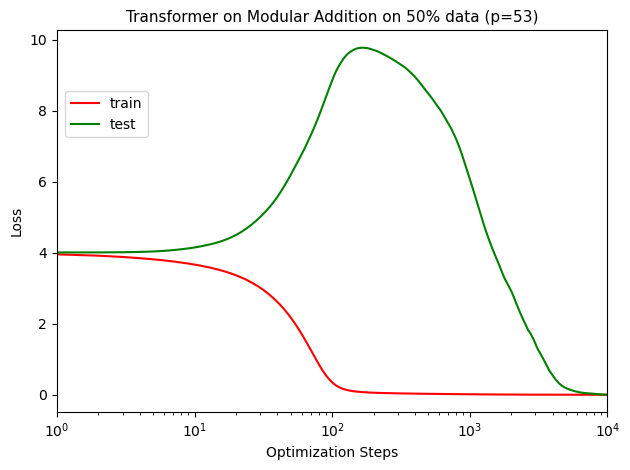

In [32]:
figure_loss = plt.subplot(1, 1, 1)
plt.plot(step, train_loss_history, color='red', label='train')
plt.plot(step, test_loss_history, color='green', label='test')
plt.legend()
plt.xlabel("Optimization Steps")
plt.xlim(1, TOTAL_STEPS)
figure_loss.set_ylabel("Loss")

plt.xscale('log')
plt.legend(loc=(0.015, 0.72))
plt.title(f"Transformer on Modular Addition on {int(100*TRAIN_FRACTION)}% data (p={P})", fontsize=11)
plt.tight_layout()